<a href="https://colab.research.google.com/github/ShreyJ1729/EVA6-TSAI/blob/main/06-BatchNorm%26Regularization/06-BatchNorm%26Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from model import Net

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = Net("BN").to(device)
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 26, 26]             910
              ReLU-6           [-1, 10, 26, 26]               0
       BatchNorm2d-7           [-1, 10, 26, 26]              20
         Dropout2d-8           [-1, 10, 26, 26]               0
            Conv2d-9           [-1, 10, 24, 24]             910
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
        Dropout2d-12           [-1, 10, 24, 24]               0
        MaxPool2d-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 10,

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [5]:
import torch

def fit(model_name, model, device, train_loader, val_loader, optimizer, epochs, loss_func, lambda_l1=0, l1reg=None, l2reg=None, scheduler=None, notebook=False, leave=False):
    model = model.to(device)

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    if notebook:
        from tqdm.notebook import tqdm
    else:
        from tqdm import tqdm

    for epoch in range(epochs):
        model.train()
        print(f"Epoch {epoch}")
        
        epoch_results = {
            "train_loss": [],
            "train_acc": [],
        }
        epoch_losses = []
        correct = 0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)

            l1_loss = 0
            if l1reg is not None:
              l1 = 0
              for p in model.parameters():
                l1 = l1 + p.abs().sum()
              l1_loss = lambda_l1 * l1
              loss = loss + l1_loss
              
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # tqdm.write(f'\r[Epoch {epoch}] loss={round(sum(epoch_losses)/len(epoch_losses), 4)}', end="")
        tqdm.write('\r[Epoch {}]\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(epoch, 
            round(sum(epoch_losses)/len(epoch_losses), 4), correct, len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))
        scheduler.step()
        
        results["train_loss"].append(round(sum(epoch_losses)/len(epoch_losses), 4))
        results["train_acc"].append(100. * correct / len(train_loader.dataset))
        
        if scheduler is not None:
          scheduler.step()

        # validation
        model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)

        tqdm.write("Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset) )
        )

        results["test_loss"].append(test_loss)
        results["test_acc"].append(100. * correct / len(test_loader.dataset) )
    
    torch.save(model, f"{model_name}.pt")
    return results

In [6]:
#Training all models

l1reg = False

final = []

for norm in ["BN", "GN", "LN"]:
  model = Net(norm).to(device)
  print(f"Training {norm} network...")
  l1reg = False
  l2reg = False
  if norm=="BN" or norm=="GN":
    l1reg = True
  if norm=="LN" or norm=="BN":
    l2reg = True
  
  if l2reg:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.85)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.85)

  results = fit(norm+"_model", model, device, train_loader, test_loader, optimizer, epochs=25, loss_func=F.nll_loss, lambda_l1 = 0.01, l1reg=l1reg, l2reg=l2reg,
                scheduler=scheduler, notebook=True, leave=True)
  final.append(results)

Training BN network...
Epoch 0



[Epoch 0]
Train set: Average loss: 3.0402, Accuracy: 44546/60000 (74.24%)
Test set: Average loss: 0.5143, Accuracy: 8787/10000 (87.87%)

Epoch 1



[Epoch 1]
Train set: Average loss: 1.8033, Accuracy: 54531/60000 (90.89%)
Test set: Average loss: 0.5412, Accuracy: 8403/10000 (84.03%)

Epoch 2



[Epoch 2]
Train set: Average loss: 1.3704, Accuracy: 54992/60000 (91.65%)
Test set: Average loss: 1.2358, Accuracy: 6256/10000 (62.56%)

Epoch 3



[Epoch 3]
Train set: Average loss: 1.2090, Accuracy: 55238/60000 (92.06%)
Test set: Average loss: 1.8678, Accuracy: 4650/10000 (46.50%)

Epoch 4



[Epoch 4]
Train set: Average loss: 1.2289, Accuracy: 55171/60000 (91.95%)
Test set: Average loss: 1.3018, Accuracy: 6028/10000 (60.28%)

Epoch 5



[Epoch 5]
Train set: Average loss: 1.2043, Accuracy: 55559/60000 (92.60%)
Test set: Average loss: 0.5850, Accuracy: 8203/10000 (82.03%)

Epoch 6



[Epoch 6]
Train set: Average loss: 1.0616, Accuracy: 55954/60000 (93.26%)
Test set: Average loss: 1.2895, Accuracy: 6280/10000 (62.80%)

Epoch 7



[Epoch 7]
Train set: Average loss: 0.9929, Accuracy: 56202/60000 (93.67%)
Test set: Average loss: 0.4193, Accuracy: 8654/10000 (86.54%)

Epoch 8



[Epoch 8]
Train set: Average loss: 0.9321, Accuracy: 56545/60000 (94.24%)
Test set: Average loss: 1.5202, Accuracy: 4750/10000 (47.50%)

Epoch 9



[Epoch 9]
Train set: Average loss: 0.8887, Accuracy: 56745/60000 (94.58%)
Test set: Average loss: 0.3265, Accuracy: 9114/10000 (91.14%)

Epoch 10



[Epoch 10]
Train set: Average loss: 0.8569, Accuracy: 56908/60000 (94.85%)
Test set: Average loss: 0.2042, Accuracy: 9476/10000 (94.76%)

Epoch 11



[Epoch 11]
Train set: Average loss: 0.8345, Accuracy: 56957/60000 (94.93%)
Test set: Average loss: 0.3481, Accuracy: 8964/10000 (89.64%)

Epoch 12



[Epoch 12]
Train set: Average loss: 0.8067, Accuracy: 57270/60000 (95.45%)
Test set: Average loss: 0.1378, Accuracy: 9618/10000 (96.18%)

Epoch 13



[Epoch 13]
Train set: Average loss: 0.7891, Accuracy: 57304/60000 (95.51%)
Test set: Average loss: 0.2081, Accuracy: 9466/10000 (94.66%)

Epoch 14



[Epoch 14]
Train set: Average loss: 0.7747, Accuracy: 57421/60000 (95.70%)
Test set: Average loss: 0.1439, Accuracy: 9628/10000 (96.28%)

Epoch 15



[Epoch 15]
Train set: Average loss: 0.7627, Accuracy: 57437/60000 (95.73%)
Test set: Average loss: 0.1500, Accuracy: 9611/10000 (96.11%)

Epoch 16



[Epoch 16]
Train set: Average loss: 0.7510, Accuracy: 57562/60000 (95.94%)
Test set: Average loss: 0.1062, Accuracy: 9752/10000 (97.52%)

Epoch 17



[Epoch 17]
Train set: Average loss: 0.7430, Accuracy: 57589/60000 (95.98%)
Test set: Average loss: 0.0847, Accuracy: 9787/10000 (97.87%)

Epoch 18



[Epoch 18]
Train set: Average loss: 0.7334, Accuracy: 57738/60000 (96.23%)
Test set: Average loss: 0.0724, Accuracy: 9829/10000 (98.29%)

Epoch 19



[Epoch 19]
Train set: Average loss: 0.7277, Accuracy: 57786/60000 (96.31%)
Test set: Average loss: 0.0794, Accuracy: 9827/10000 (98.27%)

Epoch 20



[Epoch 20]
Train set: Average loss: 0.7242, Accuracy: 57789/60000 (96.31%)
Test set: Average loss: 0.0782, Accuracy: 9820/10000 (98.20%)

Epoch 21



[Epoch 21]
Train set: Average loss: 0.7186, Accuracy: 57895/60000 (96.49%)
Test set: Average loss: 0.0864, Accuracy: 9805/10000 (98.05%)

Epoch 22



[Epoch 22]
Train set: Average loss: 0.7205, Accuracy: 57808/60000 (96.35%)
Test set: Average loss: 0.0770, Accuracy: 9846/10000 (98.46%)

Epoch 23



[Epoch 23]
Train set: Average loss: 0.7140, Accuracy: 57926/60000 (96.54%)
Test set: Average loss: 0.0730, Accuracy: 9848/10000 (98.48%)

Epoch 24



[Epoch 24]
Train set: Average loss: 0.7139, Accuracy: 57954/60000 (96.59%)
Test set: Average loss: 0.0701, Accuracy: 9845/10000 (98.45%)

Training GN network...
Epoch 0



[Epoch 0]
Train set: Average loss: 3.2958, Accuracy: 34909/60000 (58.18%)
Test set: Average loss: 0.7062, Accuracy: 7765/10000 (77.65%)

Epoch 1



[Epoch 1]
Train set: Average loss: 1.8628, Accuracy: 48119/60000 (80.20%)
Test set: Average loss: 0.4648, Accuracy: 8779/10000 (87.79%)

Epoch 2



[Epoch 2]
Train set: Average loss: 1.4857, Accuracy: 50092/60000 (83.49%)
Test set: Average loss: 0.4768, Accuracy: 8724/10000 (87.24%)

Epoch 3



[Epoch 3]
Train set: Average loss: 1.2875, Accuracy: 51836/60000 (86.39%)
Test set: Average loss: 0.4372, Accuracy: 8832/10000 (88.32%)

Epoch 4



[Epoch 4]
Train set: Average loss: 1.5243, Accuracy: 50829/60000 (84.72%)
Test set: Average loss: 0.3605, Accuracy: 9080/10000 (90.80%)

Epoch 5



[Epoch 5]
Train set: Average loss: 1.6089, Accuracy: 51606/60000 (86.01%)
Test set: Average loss: 0.4832, Accuracy: 8592/10000 (85.92%)

Epoch 6



[Epoch 6]
Train set: Average loss: 1.4605, Accuracy: 52471/60000 (87.45%)
Test set: Average loss: 0.3149, Accuracy: 9272/10000 (92.72%)

Epoch 7



[Epoch 7]
Train set: Average loss: 1.3561, Accuracy: 53061/60000 (88.44%)
Test set: Average loss: 0.4330, Accuracy: 8792/10000 (87.92%)

Epoch 8



[Epoch 8]
Train set: Average loss: 1.3217, Accuracy: 53272/60000 (88.79%)
Test set: Average loss: 0.2923, Accuracy: 9303/10000 (93.03%)

Epoch 9



[Epoch 9]
Train set: Average loss: 1.2701, Accuracy: 53597/60000 (89.33%)
Test set: Average loss: 0.2891, Accuracy: 9288/10000 (92.88%)

Epoch 10



[Epoch 10]
Train set: Average loss: 1.2269, Accuracy: 53761/60000 (89.60%)
Test set: Average loss: 0.2741, Accuracy: 9358/10000 (93.58%)

Epoch 11



[Epoch 11]
Train set: Average loss: 1.1886, Accuracy: 53960/60000 (89.93%)
Test set: Average loss: 0.2611, Accuracy: 9331/10000 (93.31%)

Epoch 12



[Epoch 12]
Train set: Average loss: 1.1574, Accuracy: 54134/60000 (90.22%)
Test set: Average loss: 0.2578, Accuracy: 9370/10000 (93.70%)

Epoch 13



[Epoch 13]
Train set: Average loss: 1.1330, Accuracy: 54426/60000 (90.71%)
Test set: Average loss: 0.2330, Accuracy: 9454/10000 (94.54%)

Epoch 14



[Epoch 14]
Train set: Average loss: 1.1081, Accuracy: 54508/60000 (90.85%)
Test set: Average loss: 0.2418, Accuracy: 9413/10000 (94.13%)

Epoch 15



[Epoch 15]
Train set: Average loss: 1.0840, Accuracy: 54826/60000 (91.38%)
Test set: Average loss: 0.2393, Accuracy: 9421/10000 (94.21%)

Epoch 16



[Epoch 16]
Train set: Average loss: 1.0722, Accuracy: 54827/60000 (91.38%)
Test set: Average loss: 0.2306, Accuracy: 9409/10000 (94.09%)

Epoch 17



[Epoch 17]
Train set: Average loss: 1.0551, Accuracy: 55016/60000 (91.69%)
Test set: Average loss: 0.2193, Accuracy: 9467/10000 (94.67%)

Epoch 18



[Epoch 18]
Train set: Average loss: 1.0466, Accuracy: 54996/60000 (91.66%)
Test set: Average loss: 0.2167, Accuracy: 9481/10000 (94.81%)

Epoch 19



[Epoch 19]
Train set: Average loss: 1.0365, Accuracy: 55132/60000 (91.89%)
Test set: Average loss: 0.2117, Accuracy: 9485/10000 (94.85%)

Epoch 20



[Epoch 20]
Train set: Average loss: 1.0291, Accuracy: 55189/60000 (91.98%)
Test set: Average loss: 0.2162, Accuracy: 9470/10000 (94.70%)

Epoch 21



[Epoch 21]
Train set: Average loss: 1.0244, Accuracy: 55309/60000 (92.18%)
Test set: Average loss: 0.2085, Accuracy: 9477/10000 (94.77%)

Epoch 22



[Epoch 22]
Train set: Average loss: 1.0221, Accuracy: 55240/60000 (92.07%)
Test set: Average loss: 0.2090, Accuracy: 9474/10000 (94.74%)

Epoch 23



[Epoch 23]
Train set: Average loss: 1.0181, Accuracy: 55298/60000 (92.16%)
Test set: Average loss: 0.2069, Accuracy: 9477/10000 (94.77%)

Epoch 24



[Epoch 24]
Train set: Average loss: 1.0161, Accuracy: 55310/60000 (92.18%)
Test set: Average loss: 0.2065, Accuracy: 9482/10000 (94.82%)

Training LN network...
Epoch 0



[Epoch 0]
Train set: Average loss: 202.3475, Accuracy: 32300/60000 (53.83%)
Test set: Average loss: 1.0264, Accuracy: 6596/10000 (65.96%)

Epoch 1



[Epoch 1]
Train set: Average loss: 97.2508, Accuracy: 43860/60000 (73.10%)
Test set: Average loss: 0.6359, Accuracy: 7942/10000 (79.42%)

Epoch 2



[Epoch 2]
Train set: Average loss: 22.7780, Accuracy: 45419/60000 (75.70%)
Test set: Average loss: 0.7957, Accuracy: 7657/10000 (76.57%)

Epoch 3



[Epoch 3]
Train set: Average loss: 2.4378, Accuracy: 45881/60000 (76.47%)
Test set: Average loss: 0.6558, Accuracy: 8274/10000 (82.74%)

Epoch 4



[Epoch 4]
Train set: Average loss: 2.1101, Accuracy: 47431/60000 (79.05%)
Test set: Average loss: 0.5973, Accuracy: 8427/10000 (84.27%)

Epoch 5



[Epoch 5]
Train set: Average loss: 1.9434, Accuracy: 48282/60000 (80.47%)
Test set: Average loss: 0.7494, Accuracy: 7759/10000 (77.59%)

Epoch 6



[Epoch 6]
Train set: Average loss: 1.8294, Accuracy: 49026/60000 (81.71%)
Test set: Average loss: 0.4926, Accuracy: 8800/10000 (88.00%)

Epoch 7



[Epoch 7]
Train set: Average loss: 1.7211, Accuracy: 49956/60000 (83.26%)
Test set: Average loss: 0.4837, Accuracy: 8766/10000 (87.66%)

Epoch 8



[Epoch 8]
Train set: Average loss: 1.6487, Accuracy: 50462/60000 (84.10%)
Test set: Average loss: 0.4547, Accuracy: 8871/10000 (88.71%)

Epoch 9



[Epoch 9]
Train set: Average loss: 1.5761, Accuracy: 51077/60000 (85.13%)
Test set: Average loss: 0.4279, Accuracy: 8949/10000 (89.49%)

Epoch 10



[Epoch 10]
Train set: Average loss: 1.5084, Accuracy: 51847/60000 (86.41%)
Test set: Average loss: 0.3943, Accuracy: 9051/10000 (90.51%)

Epoch 11



[Epoch 11]
Train set: Average loss: 1.4681, Accuracy: 52031/60000 (86.72%)
Test set: Average loss: 0.3926, Accuracy: 9006/10000 (90.06%)

Epoch 12



[Epoch 12]
Train set: Average loss: 1.4214, Accuracy: 52516/60000 (87.53%)
Test set: Average loss: 0.3637, Accuracy: 9103/10000 (91.03%)

Epoch 13



[Epoch 13]
Train set: Average loss: 1.3841, Accuracy: 52891/60000 (88.15%)
Test set: Average loss: 0.3546, Accuracy: 9132/10000 (91.32%)

Epoch 14



[Epoch 14]
Train set: Average loss: 1.3620, Accuracy: 53008/60000 (88.35%)
Test set: Average loss: 0.3408, Accuracy: 9173/10000 (91.73%)

Epoch 15



[Epoch 15]
Train set: Average loss: 1.3356, Accuracy: 53377/60000 (88.96%)
Test set: Average loss: 0.3395, Accuracy: 9178/10000 (91.78%)

Epoch 16



[Epoch 16]
Train set: Average loss: 1.3169, Accuracy: 53504/60000 (89.17%)
Test set: Average loss: 0.3420, Accuracy: 9182/10000 (91.82%)

Epoch 17



[Epoch 17]
Train set: Average loss: 1.3069, Accuracy: 53650/60000 (89.42%)
Test set: Average loss: 0.3239, Accuracy: 9247/10000 (92.47%)

Epoch 18



[Epoch 18]
Train set: Average loss: 1.2936, Accuracy: 53751/60000 (89.58%)
Test set: Average loss: 0.3172, Accuracy: 9233/10000 (92.33%)

Epoch 19



[Epoch 19]
Train set: Average loss: 1.2811, Accuracy: 53896/60000 (89.83%)
Test set: Average loss: 0.3131, Accuracy: 9270/10000 (92.70%)

Epoch 20



[Epoch 20]
Train set: Average loss: 1.2719, Accuracy: 53985/60000 (89.97%)
Test set: Average loss: 0.3242, Accuracy: 9235/10000 (92.35%)

Epoch 21



[Epoch 21]
Train set: Average loss: 1.2703, Accuracy: 53997/60000 (90.00%)
Test set: Average loss: 0.3062, Accuracy: 9296/10000 (92.96%)

Epoch 22



[Epoch 22]
Train set: Average loss: 1.2626, Accuracy: 54150/60000 (90.25%)
Test set: Average loss: 0.3068, Accuracy: 9297/10000 (92.97%)

Epoch 23



[Epoch 23]
Train set: Average loss: 1.2580, Accuracy: 54154/60000 (90.26%)
Test set: Average loss: 0.3072, Accuracy: 9291/10000 (92.91%)

Epoch 24



[Epoch 24]
Train set: Average loss: 1.2577, Accuracy: 54120/60000 (90.20%)
Test set: Average loss: 0.3005, Accuracy: 9304/10000 (93.04%)



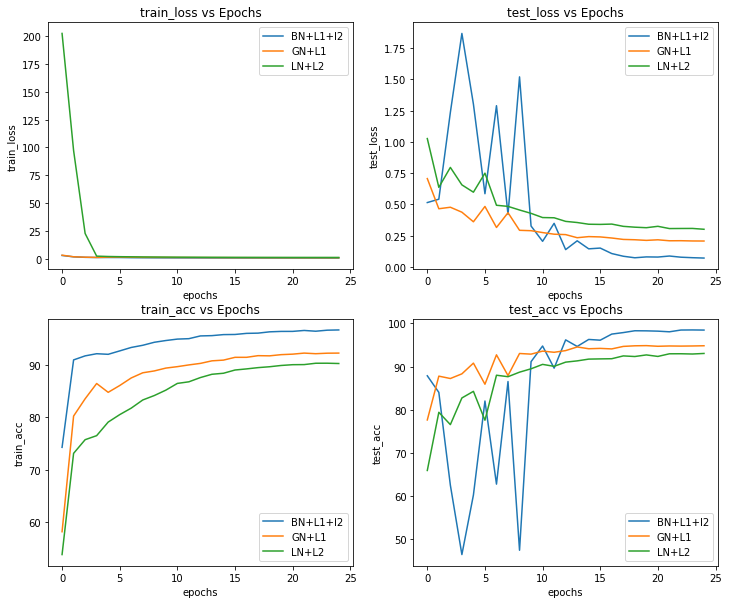

In [7]:
# Test loss plot:
# 0 - BN+L1
# 1 - GN
# 2 - LN

import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
index=1
for metric in ["train_loss", "test_loss", "train_acc", "test_acc"]:
  plt.subplot(2, 2, index)
  plt.plot(final[0][metric], label="BN+L1+l2")
  plt.plot(final[1][metric], label="GN+L1")
  plt.plot(final[2][metric], label="LN+L2")
  plt.legend()
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.title(f"{metric} vs Epochs")
  index+=1
plt.show()

Misclassified images for BN_model:


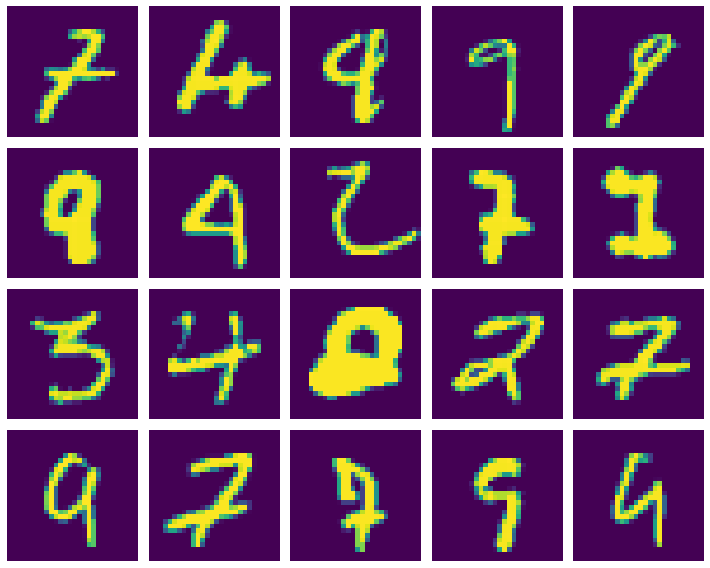

Misclassified images for GN_model:


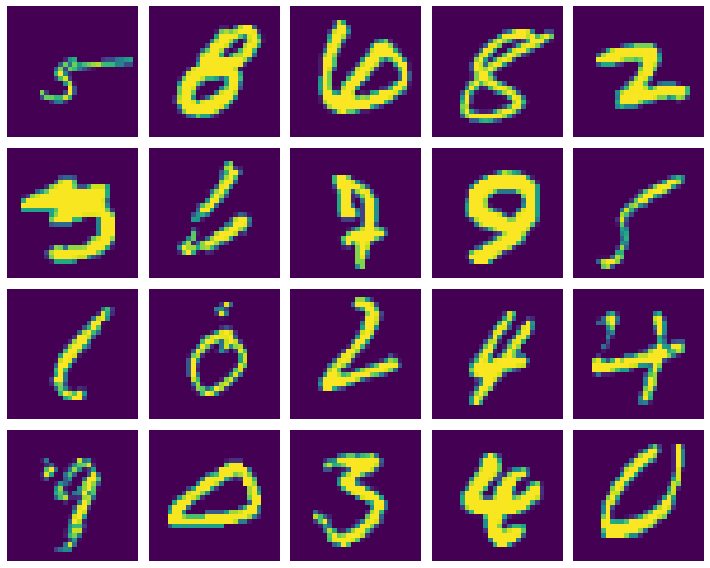

Misclassified images for LN_model:


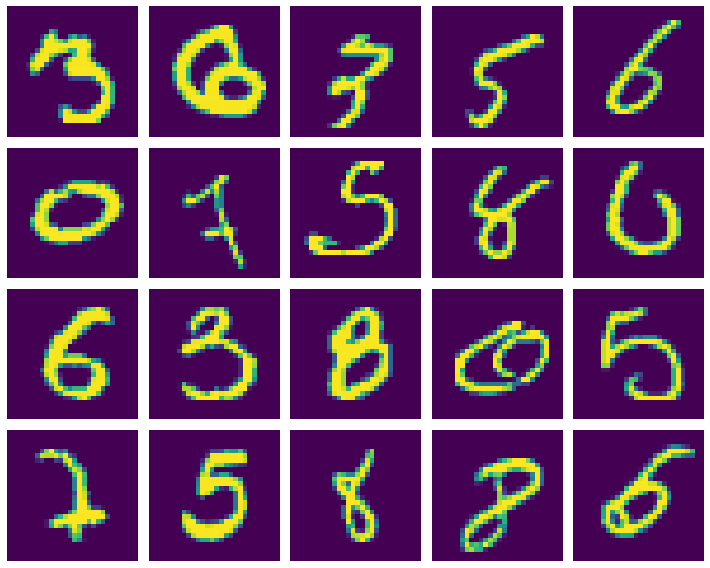

In [8]:
for path in ["BN_model.pt", "GN_model.pt", "LN_model.pt"]:
  model = torch.load(path)
  count = 0
  badimages = []
  badpreds = []
  badlabels = []
  for (data, labels) in test_loader:
    data = data.to(device)
    preds = model(data).cpu()
    preds = torch.argmax(preds, 1)
    matches = preds.eq(labels)
    for i in range(len(matches)):
      if matches[i]==False:
        count+=1
        badimages.append(data[i])
        badpreds.append(preds[i])
        badlabels.append(labels[i])
      if count==20: break
    if count==20: break
  
  print(f"Misclassified images for {path.split('.')[0]}:")
  plt.figure(figsize=(10, 8))
  for idx, image in enumerate(badimages):
    plt.subplot(4, 5, idx+1)
    plt.axis("off")
    plt.imshow(image.cpu()[0])
  plt.tight_layout()
  plt.show()